# Exploratory code to compare CT processing pipelines
    1. Dataset: ABIDE (https://riojournal.com/article/13726/) 
    2. Pipelines: ANTS, FreeSurfer, CIVET
    3. Atlas: DKT
    4. Plots: data distributoins, clusters, t-sne
    5. Analysis: statistical models (e.g. OLS, ML classifiers) 
    
## DX: 1 Autism, 2: Controls

In [1]:
# basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [10]:
missing_val_file = '/home/nikhil/projects/CT_reproduce/data/fs60_vertex_out/missing_val_lh.test'
missing_data = pd.read_csv(missing_val_file)
missing_data.shape

(905, 6)

In [13]:
missing_data.sum()

22    2404.166785
23    2076.503315
24    2294.814061
25    1903.803042
26    2824.071674
27    2348.050366
dtype: float64

## Paths

In [2]:
proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
data_dir = proj_dir + 'data/'
#data_dir = '/Users/nikhil/code/git_repos/compare-surf-tools/data/'

ants_file = 'ABIDE_ants_thickness_data.csv'
fs53_file = 'ABIDE_fs5.3_thickness.csv'
fs51_file = 'cortical_fs5.1_measuresenigma_thickavg.csv'  
subject_chk_file = 'subject_check.csv'
pheno_file = 'ABIDE_Phenotype.csv'

#outlier_file = '/Users/nikhil/Downloads/OutliersGroupPipe.csv'
#outlier_file = '/Users/nikhil/Downloads/nonAdjOutliersGroupPipe.csv'
study_file = data_dir + 'standardized/study_data_df.csv'

outlier_file = '/outliers/ageOutliersGroupPipeline_v4.csv'
fs60_file_lh = 'aparc_lh_thickness_table.txt'
fs60_file_rh = 'aparc_rh_thickness_table.txt'

## Read data

In [3]:
ants_data = pd.read_csv(data_dir + ants_file, header=2)
fs53_data = pd.read_csv(data_dir + fs53_file)
fs51_data = pd.read_csv(data_dir + fs51_file)

fs60_data_lh = pd.read_csv(data_dir + fs60_file_lh,delim_whitespace=True)
fs60_data_rh = pd.read_csv(data_dir + fs60_file_rh,delim_whitespace=True)

subject_ckh = pd.read_csv(data_dir + subject_chk_file)
pheno = pd.read_csv(data_dir + pheno_file)
pheno = pheno.rename(columns={'Subject_ID':'SubjID'})
#outlier_data = pd.read_csv(data_dir + outlier_file)
#study_data = pd.read_csv(study_file)

/Users/nikhil/anaconda/envs/3D_UNet_clone/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(300, 8)


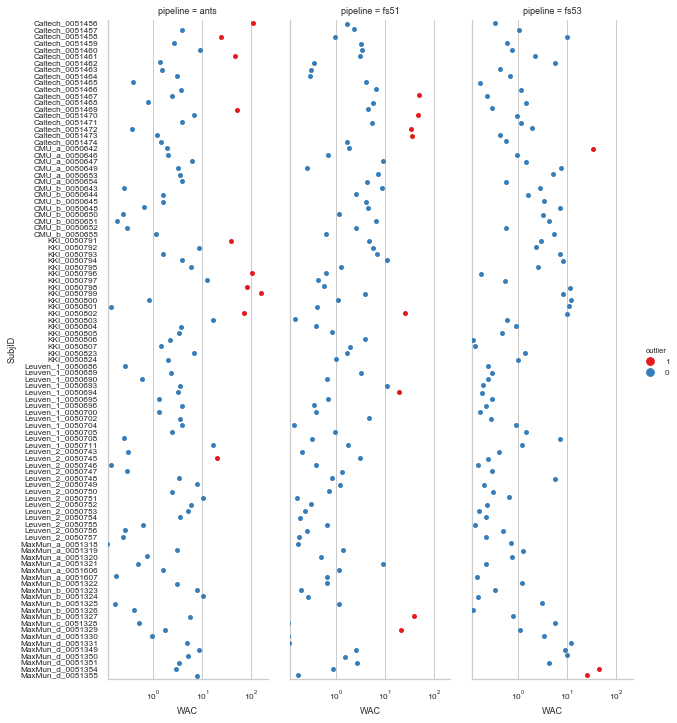

In [47]:
sample_outliers = outlier_data[outlier_data['DX_GROUP']==1]['SubjID'].values[:100]

plot_df = outlier_data[outlier_data['SubjID'].isin(sample_outliers)]
plot_df['WAC'] = plot_df['sumHim']
print(plot_df.shape)
sns.set(font_scale=0.75)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='WAC',y='SubjID',col='pipeline',kind='strip',hue='outlier',
                    data=plot_df,palette='Set1',height=10,aspect=0.3,hue_order=[1,0])
    g.set(xscale="log");


In [49]:

g.savefig('/Users/nikhil/Desktop/outlier.png', dpi=800)

In [74]:
print('dataframe shapes:')
print('pheno {}, ants {}, fs51 {}. fs53 {}'.format(pheno.shape, ants_data.shape, 
                                                   fs51_data.shape, fs53_data.shape))
print('\noutlier counts:')
pipe_outlier = {}
for pipe in set(outlier_data['pipeline']):
    p_o = outlier_data[(outlier_data['pipeline']==pipe) & (outlier_data['outlier']==1)]['SubjID'].values
    pipe_outlier[pipe] = p_o
    print('{} {}'.format(pipe, np.shape(p_o)[0]))
    
# outlier overlap
print(len(set(pipe_outlier['ants']) & set(pipe_outlier['fs51'])))
print(len(set(pipe_outlier['ants']) & set(pipe_outlier['fs53'])))
print(len(set(pipe_outlier['fs51']) & set(pipe_outlier['fs53'])))

dataframe shapes:
pheno (1112, 102), ants (1101, 99), fs51 (1112, 75). fs53 (976, 74)

outlier counts:
fs53 60
fs51 29
ants 46
1
2
2


## Create unified list of ROIs

In [4]:
# ANTS
ants_useful_cols = ['Structure Name']
ants_to_std_naming_dict = {}
ants_to_std_naming_dict['Structure Name'] = 'SubjID'
for roi in ants_data.columns:
    prefix = None
    name_split = roi.split(' ')
    if name_split[0] == 'left':
        prefix = 'L'
    if name_split[0] == 'right':
        prefix = 'R'

    if prefix is not None:
        ants_useful_cols.append(roi)
        std_name = prefix + '_' + ''.join(name_split[1:])
        ants_to_std_naming_dict[roi] = std_name

In [5]:
# FS
fs_useful_cols = ['SubjID']
fs_col_renames = {}
for roi in fs51_data.columns:
    prefix = None
    name_split = roi.split('_')
    if name_split[0] in ['L','R']:
        roi_rename = name_split[0] + '_' + name_split[1]
        fs_useful_cols.append(roi_rename)
        fs_col_renames[roi] = roi_rename
        
fs51_data = fs51_data.rename(columns=fs_col_renames)
fs53_data = fs53_data.rename(columns=fs_col_renames)

In [6]:
# Parse and combine fs60 left and right data
# left
fs60_data_lh['SiteID'] = fs60_data_lh['lh.aparc.thickness'].str.split('/',expand=True)[1]
fs60_data_lh['SiteID'] = fs60_data_lh['SiteID'].str.split('.',expand=True)[0]
fs60_data_lh[['runid','SubjID']] = fs60_data_lh['SiteID'].str.split('_',n=1,expand=True)

# right
fs60_data_rh['SiteID'] = fs60_data_rh['rh.aparc.thickness'].str.split('/',expand=True)[1]
fs60_data_rh['SiteID'] = fs60_data_rh['SiteID'].str.split('.',expand=True)[0]
fs60_data_rh[['runid','SubjID']] = fs60_data_rh['SiteID'].str.split('_',n=1,expand=True)

# merge left and right (use the tagged run1)
fs60_data_lh_filtered = fs60_data_lh[fs60_data_lh['runid']=='run1'][[col for col in fs60_data_lh.columns if '_thickness' in col]+['SubjID']]
fs60_data_rh_filtered = fs60_data_rh[fs60_data_rh['runid']=='run1'][[col for col in fs60_data_rh.columns if '_thickness' in col]+['SubjID']] 
fs60_data = pd.merge(fs60_data_lh_filtered, fs60_data_rh_filtered, on='SubjID', how='inner')
print('shape of left and right merge fs6.0 df {}'.format(fs60_data.shape))

# rename columns
fs60_col_renames ={}
for roi in fs60_data.columns:
    prefix = None
    if roi not in ['SubjID','lh_MeanThickness_thickness','rh_MeanThickness_thickness']:
        name_split = roi.split('_')
        if name_split[0] == 'lh':
            prefix = 'L'
            roi_rename = prefix + '_' + name_split[1]
        if name_split[0] == 'rh':
            prefix = 'R'
            roi_rename = prefix + '_' + name_split[1]

        fs60_col_renames[roi] = roi_rename
        
fs60_data = fs60_data.rename(columns=fs60_col_renames)
print('shape of fs6.0 df after column rename {}'.format(fs60_data.shape))

shape of left and right merge fs6.0 df (862, 71)
shape of fs6.0 df after column rename (862, 71)


In [7]:
# standardize common naming, subjects, and columns
ants_data_std = ants_data[ants_useful_cols]
ants_data_std = ants_data_std.rename(columns=ants_to_std_naming_dict)

fs51_data_std = fs51_data[fs_useful_cols]
fs53_data_std = fs53_data[fs_useful_cols]
fs60_data_std = fs60_data[fs_useful_cols]
print('ANTS, FS 5.1, 5.3, 6.0 data shapes {}, {}, {}, {}'.format(ants_data_std.shape, fs51_data_std.shape, 
                                                                 fs53_data_std.shape, fs60_data_std.shape))

# Common columns 
common_cols = list(set(ants_data_std.columns) & set(fs51_data_std.columns))
common_roi_cols = common_cols[:] #.copy()
common_roi_cols.remove('SubjID')
ants_data_std = ants_data_std[common_cols]
ants_data_std['pipeline'] = np.tile('ants',len(ants_data_std))
fs51_data_std = fs51_data_std[common_cols]
fs51_data_std['pipeline'] = np.tile('fs51',len(fs51_data_std))
fs53_data_std = fs53_data_std[common_cols]
fs53_data_std['pipeline'] = np.tile('fs53',len(fs53_data_std))
fs60_data_std = fs60_data_std[common_cols]
fs60_data_std['pipeline'] = np.tile('fs60',len(fs60_data_std))

# Common subjects
common_subs = list(set(ants_data_std['SubjID'].values) & set(fs51_data_std['SubjID'].values) 
                   & set(fs53_data_std['SubjID'].values) & set(fs60_data_std['SubjID'].values))
ants_data_std = ants_data_std[ants_data_std['SubjID'].isin(common_subs)]
fs51_data_std = fs51_data_std[fs51_data_std['SubjID'].isin(common_subs)]
fs53_data_std = fs53_data_std[fs53_data_std['SubjID'].isin(common_subs)]
fs60_data_std = fs60_data_std[fs60_data_std['SubjID'].isin(common_subs)]

print('After selecting common subjects {} and columns {}\nData shapes for ants {}, FS 5.1 {}, FS 5.3 {},  FS 6.0 {}'.format(len(common_subs), 
                                                                                                                len(common_cols),
                                                                                                                ants_data_std.shape,
                                                                                                                fs51_data_std.shape,
                                                                                                                fs53_data_std.shape,
                                                                                                                fs60_data_std.shape))

ANTS, FS 5.1, 5.3, 6.0 data shapes (1101, 90), (1112, 69), (976, 69), (862, 69)
After selecting common subjects 760 and columns 63
Data shapes for ants (760, 64), FS 5.1 (760, 64), FS 5.3 (760, 64),  FS 6.0 (760, 64)


In [82]:
# Add the outlier column for each pipeline df
ants_data_std = pd.merge(ants_data_std,outlier_data[outlier_data['pipeline']=='ants'][['SubjID','outlier','groupSowft']],
                        how='inner',on='SubjID')
#ants_data_std = ants_data_std.fillna(0)
fs51_data_std = pd.merge(fs51_data_std,outlier_data[outlier_data['pipeline']=='fs51'][['SubjID','outlier','groupSowft']],
                        how='inner',on='SubjID')
#fs51_data_std = fs51_data_std.fillna(0)
fs53_data_std = pd.merge(fs53_data_std,outlier_data[outlier_data['pipeline']=='fs53'][['SubjID','outlier','groupSowft']],
                        how='inner',on='SubjID')
#fs53_data_std = fs53_data_std.fillna(0)
print(ants_data_std.shape,fs51_data_std.shape,fs53_data_std.shape)

(760, 67) (760, 67) (760, 67)


In [14]:
# Melt the longform df for plotting... 
master_data_df = ants_data_std.append(fs51_data_std).append(fs53_data_std).append(fs60_data_std)
useful_demograph = pheno[['SubjID','SEX','AGE_AT_SCAN','DX_GROUP']]
master_data_df = pd.merge(master_data_df, useful_demograph, how='left', on='SubjID')
print(master_data_df.shape)

master_data_df_melt = pd.melt(master_data_df, id_vars=['SubjID','pipeline','DX_GROUP'], 
                              value_vars=common_roi_cols, var_name='ROI', value_name='thickness')
# master_data_df_melt = pd.melt(master_data_df, id_vars=['SubjID','pipeline','outlier','groupSowft','DX_GROUP'], 
#                               value_vars=common_roi_cols, var_name='ROI', value_name='thickness')

#master_data_df_melt[['ROI','measure']] = master_data_df_melt['ROI'].str.split('_',expand=True)[1:3]

(3040, 67)


## Plots: distributions

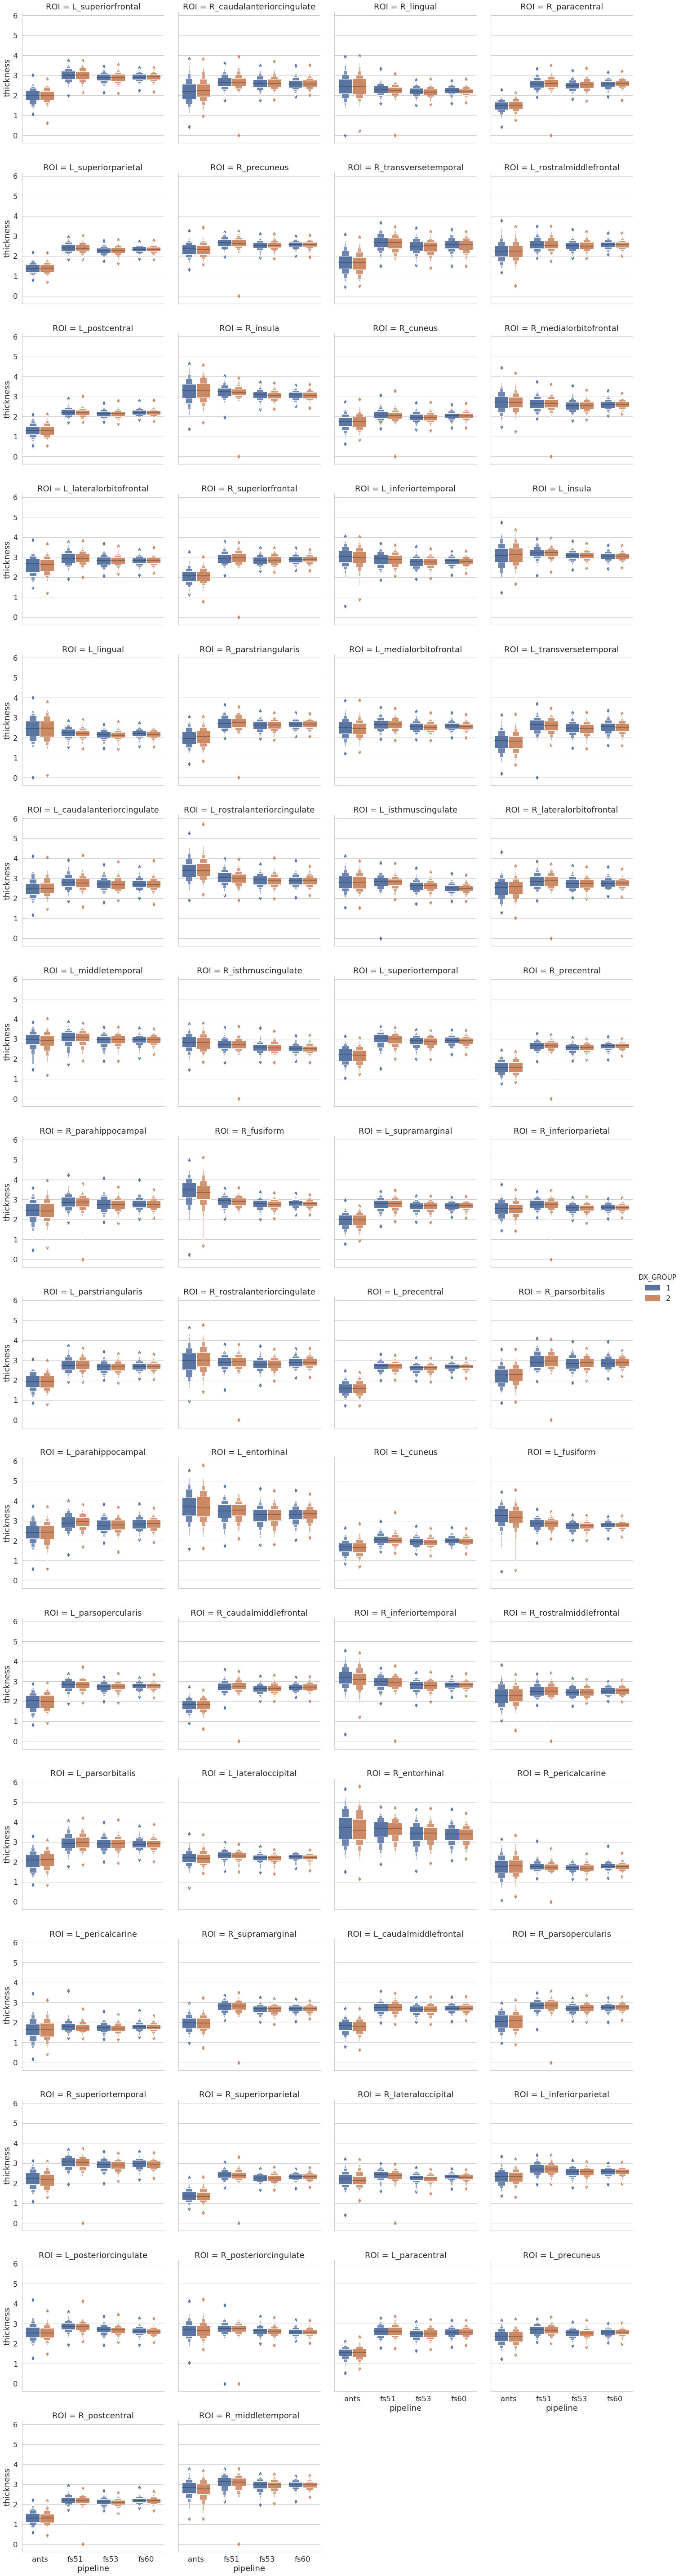

In [15]:
sns.set(font_scale=1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='thickness', x='pipeline', hue='DX_GROUP', kind='boxen', col='ROI', col_wrap=4, 
                    data=master_data_df_melt)


## Filter df based on outliers and concat (horizontally)

In [16]:
include_sub_tags = [0,1] # if 0 implies exclude outliers; else use [0,1]  

ants_data_std_filtered = ants_data_std #[ants_data_std['outlier'].isin(include_sub_tags)]
ants_data_corr = ants_data_std_filtered[common_cols]
ants_data_corr.columns = [str(col) + '_ants' for col in ants_data_corr.columns]
ants_data_corr = ants_data_corr.rename(columns={'SubjID_ants':'SubjID'})

fs51_data_std_filtered = fs51_data_std #[fs51_data_std['outlier'].isin(include_sub_tags)]
fs51_data_corr = fs51_data_std_filtered[common_cols]
fs51_data_corr.columns = [str(col) + '_fs51' for col in fs51_data_corr.columns]
fs51_data_corr = fs51_data_corr.rename(columns={'SubjID_fs51':'SubjID'})

fs53_data_std_filtered = fs53_data_std #[fs53_data_std['outlier'].isin(include_sub_tags)]
fs53_data_corr = fs53_data_std_filtered[common_cols]
fs53_data_corr.columns = [str(col) + '_fs53' for col in fs53_data_corr.columns]
fs53_data_corr = fs53_data_corr.rename(columns={'SubjID_fs53':'SubjID'})

fs60_data_std_filtered = fs60_data_std #[fs60_data_std['outlier'].isin(include_sub_tags)]
fs60_data_corr = fs60_data_std_filtered[common_cols]
fs60_data_corr.columns = [str(col) + '_fs60' for col in fs53_data_corr.columns]
fs60_data_corr = fs60_data_corr.rename(columns={'SubjID_fs60':'SubjID'})

concat_df = ants_data_corr.merge(fs51_data_corr, on='SubjID').merge(fs53_data_corr, on='SubjID').merge(fs60_data_corr, on='SubjID')
print('shape after concat {}'.format(concat_df.shape))

shape after concat (760, 249)


In [ ]:
#Before 
avg corr:
ants-fs51 0.427, ants-fs53 0.474, fs51-fs53 0.875
stdev corr:
ants-fs51 0.117, ants-fs53 0.118, fs51-fs53 0.036

# After
avg corr:
ants-fs51 0.427, ants-fs53 0.473, fs51-fs53 0.870
stdev corr:
ants-fs51 0.118, ants-fs53 0.120, fs51-fs53 0.038


## Plots: correlations

avg corr:
ants-fs51 0.429, ants-fs53 0.474, ants-fs60 0.432, fs51-fs53 0.877, fs51-fs60 0.845, fs53-fs60 0.908
stdev corr:
ants-fs51 0.115, ants-fs53 0.116, ants-fs60 0.123, fs51-fs53 0.040, fs51-fs60 0.046, fs53-fs60 0.035


/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


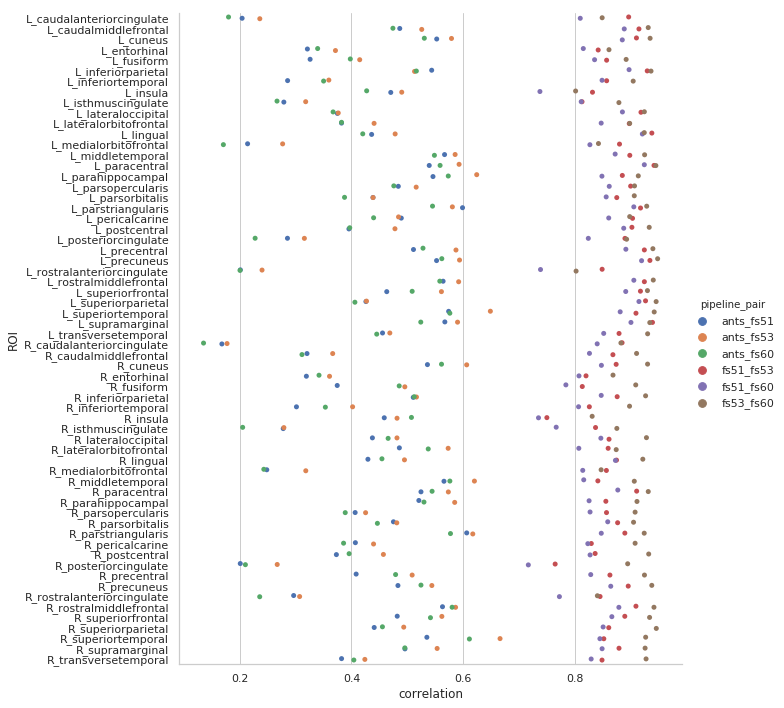

In [41]:
corr = concat_df.corr()

# avg cross-correlations using diangonals (corrwith from pandas doesn't work)
n_roi = 62
ants_fs51 = corr.values[:n_roi,n_roi:2*n_roi].diagonal()
ants_fs53 = corr.values[:n_roi,2*n_roi:3*n_roi].diagonal()
ants_fs60 = corr.values[:n_roi,3*n_roi:4*n_roi].diagonal()
fs51_fs53 = corr.values[n_roi:2*n_roi,2*n_roi:3*n_roi].diagonal()
fs51_fs60 = corr.values[n_roi:2*n_roi,3*n_roi:4*n_roi].diagonal()
fs53_fs60 = corr.values[2*n_roi:3*n_roi,3*n_roi:4*n_roi].diagonal()

print('avg corr:\nants-fs51 {:4.3f}, ants-fs53 {:4.3f}, ants-fs60 {:4.3f}, fs51-fs53 {:4.3f}, fs51-fs60 {:4.3f}, fs53-fs60 {:4.3f}'.format(np.mean(ants_fs51),
                                                                   np.mean(ants_fs53),
                                                                   np.mean(ants_fs60),
                                                                   np.mean(fs51_fs53),
                                                                   np.mean(fs51_fs60),
                                                                   np.mean(fs53_fs60)))

print('stdev corr:\nants-fs51 {:4.3f}, ants-fs53 {:4.3f}, ants-fs60 {:4.3f}, fs51-fs53 {:4.3f}, fs51-fs60 {:4.3f}, fs53-fs60 {:4.3f}'.format(np.std(ants_fs51),
                                                                   np.std(ants_fs53),
                                                                   np.std(ants_fs60),
                                                                   np.std(fs51_fs53),
                                                                   np.std(fs51_fs60),
                                                                   np.std(fs53_fs60)))


# plot all pair-wise corrs (not really needed for seeing inter-pipeline comparisons)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#cmap = sns.diverging_palette(220, 20, n=7)

# Draw the heatmap with the mask and correct aspect ratio
# plt.figure(figsize=(20,20))
# sns.set(font_scale=1)
# sns.heatmap(corr, cmap=cmap, square=True, linewidths=.5,center=0)

# Plot roi-wise correlation
df_corr_pairs = pd.DataFrame(columns=['correlation','ROI','pipeline_pair'])
ants_fs51_df = pd.DataFrame(columns=['correlation','ROI','pipeline_pair'])
ants_fs51_df['correlation'] =  ants_fs51
ants_fs51_df['ROI'] = common_roi_cols
ants_fs51_df['pipeline_pair'] = np.tile('ants_fs51',n_roi)

ants_fs53_df = pd.DataFrame(columns=['corr','ROI','pipeline_pair'])
ants_fs53_df['correlation'] =  ants_fs53
ants_fs53_df['ROI'] = common_roi_cols
ants_fs53_df['pipeline_pair'] = np.tile('ants_fs53',n_roi)

df_corr_pairs = pd.DataFrame(columns=['correlation','ROI','pipeline_pair'])
ants_fs60_df = pd.DataFrame(columns=['correlation','ROI','pipeline_pair'])
ants_fs60_df['correlation'] =  ants_fs60
ants_fs60_df['ROI'] = common_roi_cols
ants_fs60_df['pipeline_pair'] = np.tile('ants_fs60',n_roi)

fs51_fs53_df = pd.DataFrame(columns=['corr','ROI','pipeline_pair'])
fs51_fs53_df['correlation'] =  fs51_fs53
fs51_fs53_df['ROI'] = common_roi_cols
fs51_fs53_df['pipeline_pair'] = np.tile('fs51_fs53',n_roi)

fs51_fs60_df = pd.DataFrame(columns=['corr','ROI','pipeline_pair'])
fs51_fs60_df['correlation'] =  fs51_fs60
fs51_fs60_df['ROI'] = common_roi_cols
fs51_fs60_df['pipeline_pair'] = np.tile('fs51_fs60',n_roi)

fs53_fs60_df = pd.DataFrame(columns=['corr','ROI','pipeline_pair'])
fs53_fs60_df['correlation'] =  fs53_fs60
fs53_fs60_df['ROI'] = common_roi_cols
fs53_fs60_df['pipeline_pair'] = np.tile('fs53_fs60',n_roi)

df_corr_pairs = df_corr_pairs.append(ants_fs51_df).append(ants_fs53_df).append(ants_fs60_df).append(fs51_fs53_df).append(fs51_fs60_df).append(fs53_fs60_df)

roi_order = sorted(list(df_corr_pairs['ROI'].unique()))
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='correlation',y='ROI',hue='pipeline_pair',order=roi_order,
                data=df_corr_pairs,aspect=1,height=10,kind='strip')
    

In [16]:
g.savefig('/Users/nikhil/Desktop/roi_compare.png', dpi=400)

## Plots: clusters

Text(0.5, 0.98, 'fs5.3')

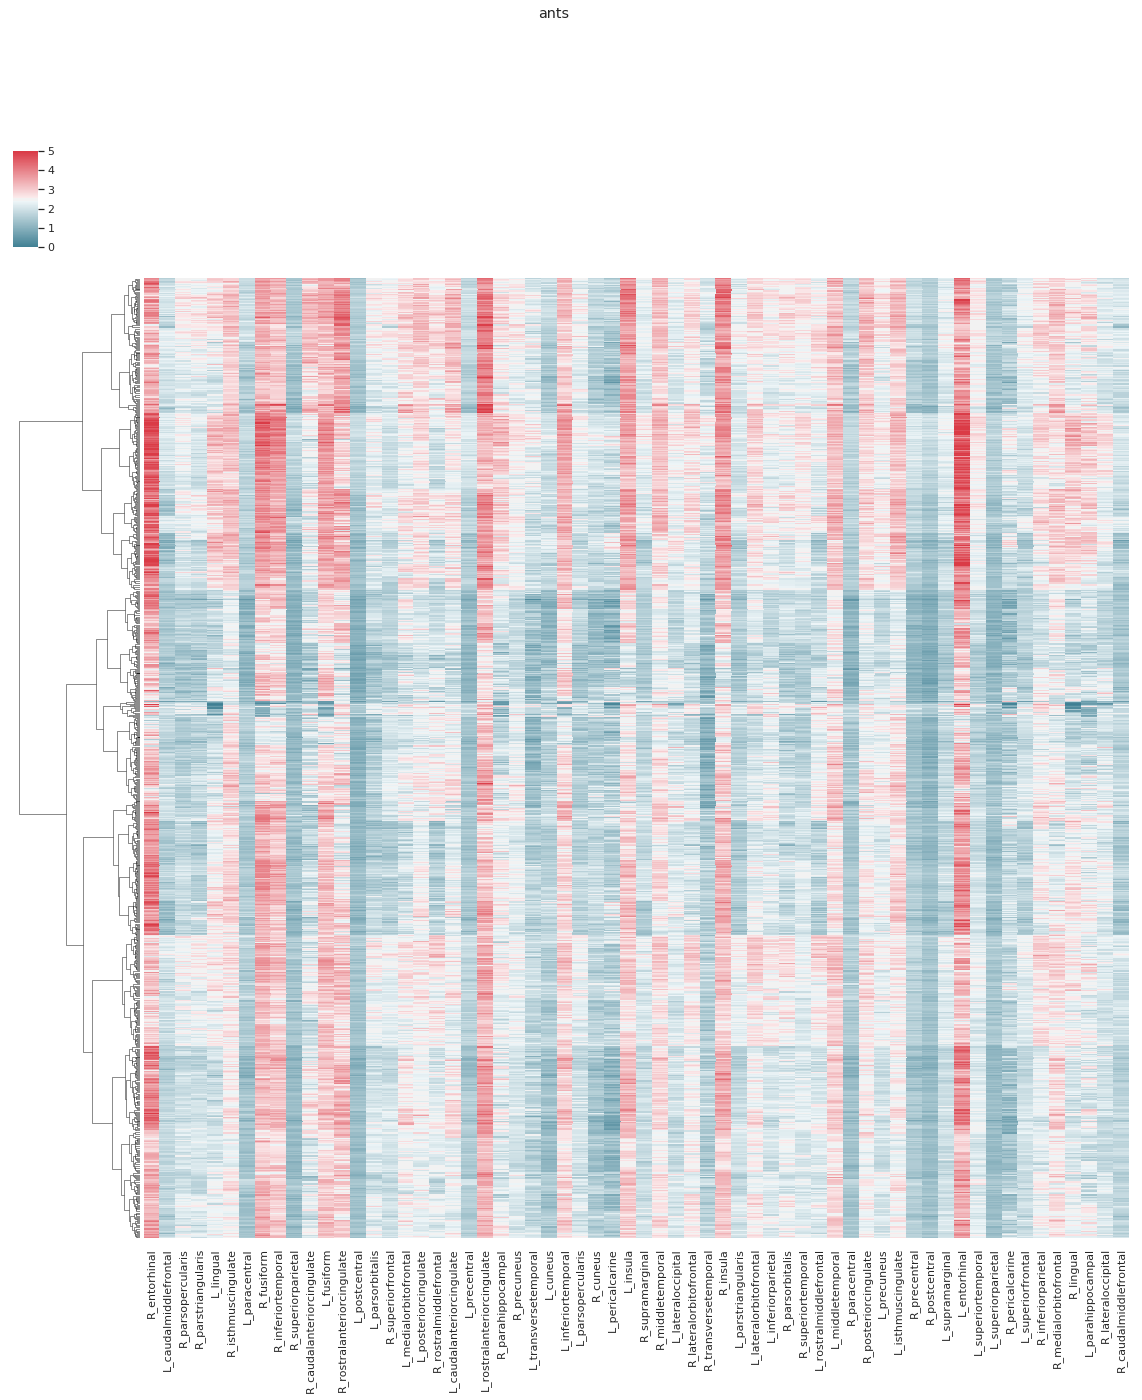

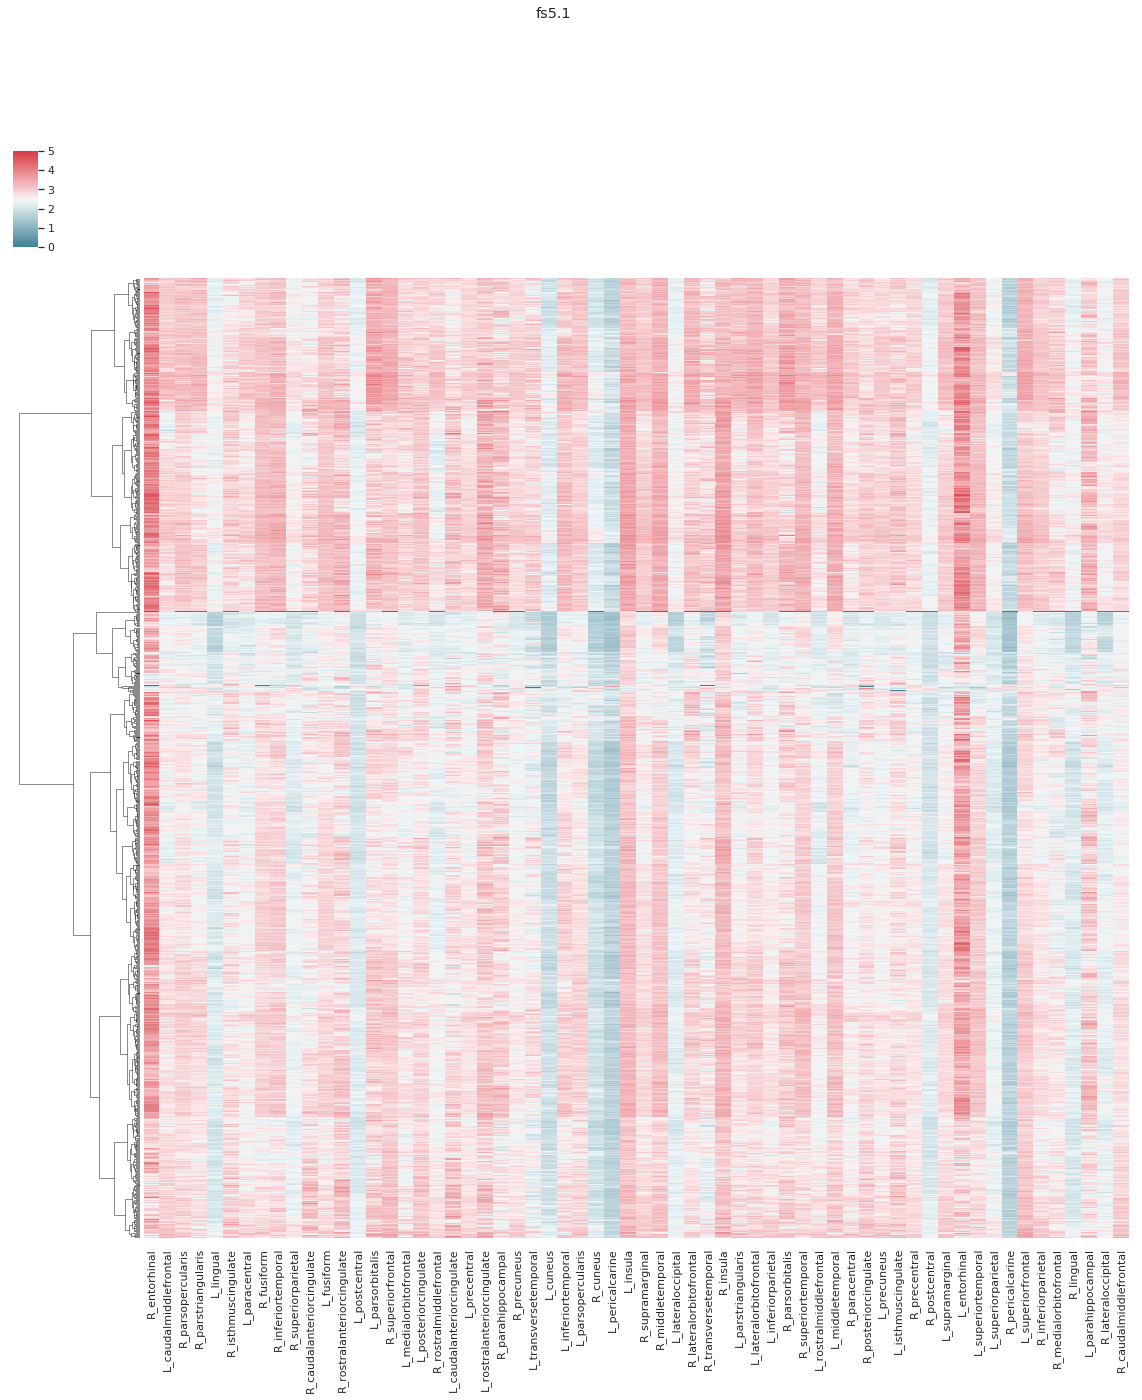

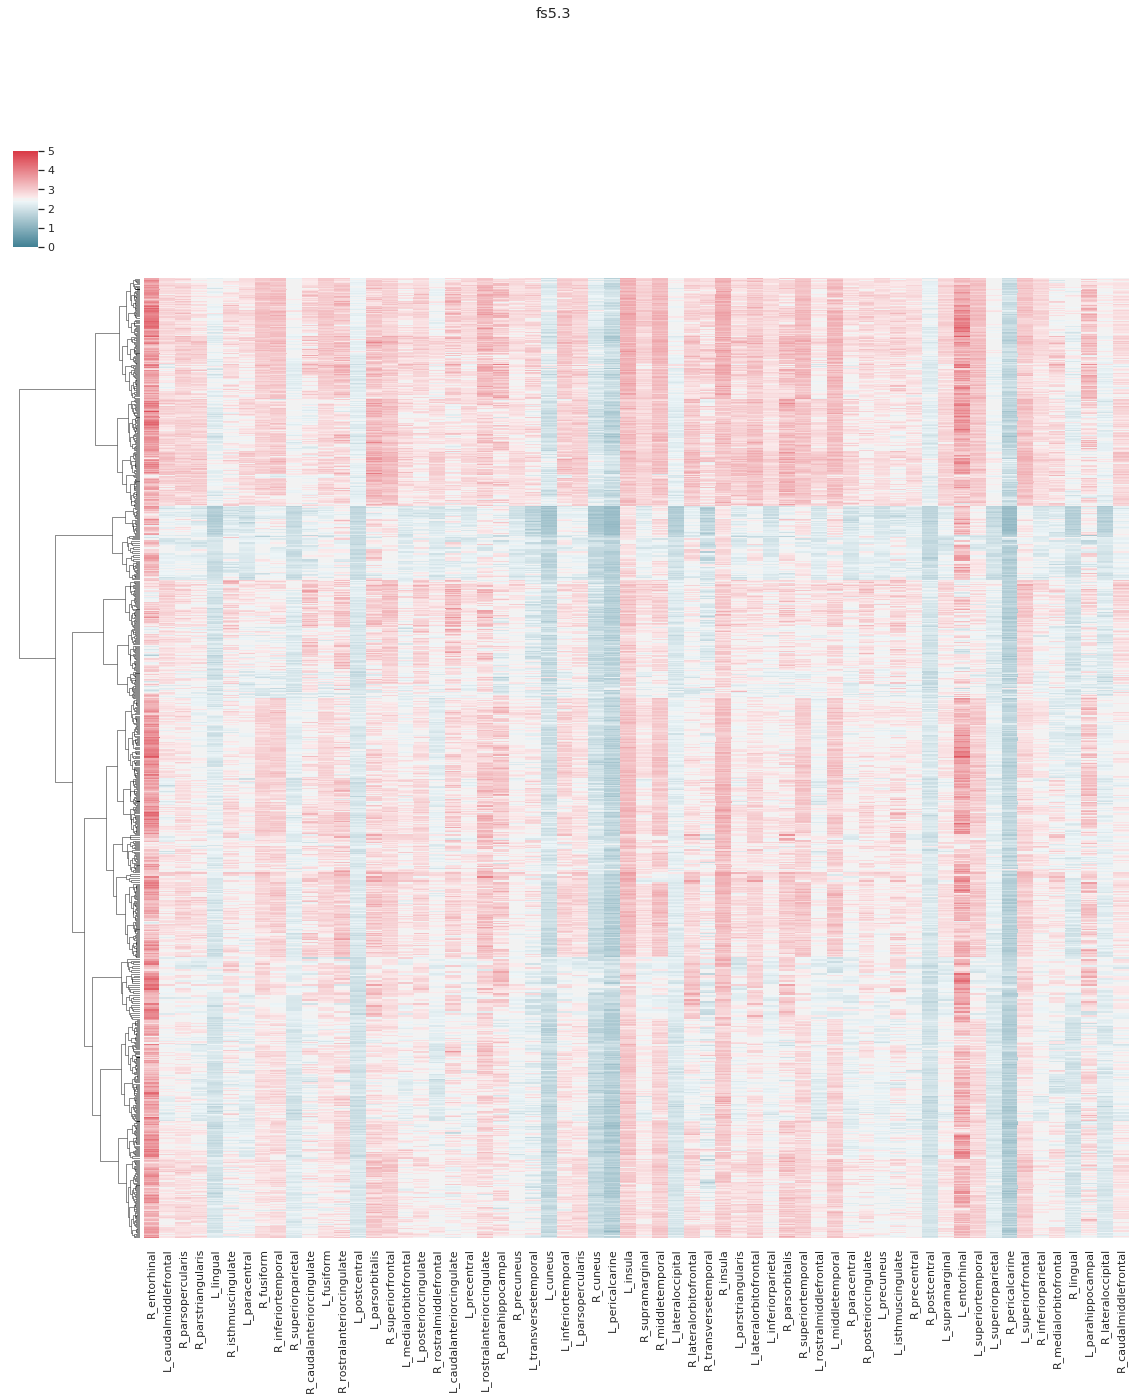

In [62]:
sns.set(style="white")
sns.set(font_scale=1)

similarity = 'euclidean'#'euclidean' #correlation
linkage = 'ward'

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

g1 = sns.clustermap(ants_data_std_filtered[common_roi_cols], row_cluster=True, col_cluster=False, metric = similarity, method=linkage, 
                   cmap=cmap, vmin=0, vmax=5, figsize=(20, 20),xticklabels=True, yticklabels=False)
g1.fig.suptitle('ants')

g2 = sns.clustermap(fs51_data_std_filtered[common_roi_cols], row_cluster=True, col_cluster=False, metric = similarity, method=linkage, 
                   cmap=cmap, vmin=0, vmax=5, figsize=(20, 20),xticklabels=True, yticklabels=False)
g2.fig.suptitle('fs5.1')

g3 = sns.clustermap(fs53_data_std_filtered[common_roi_cols], row_cluster=True, col_cluster=False, metric = similarity, method=linkage, 
                   cmap=cmap, vmin=0, vmax=5, figsize=(20, 20),xticklabels=True, yticklabels=False)
g3.fig.suptitle('fs5.3')

In [63]:
# cluster memberships
# Very basic - assumes same order of cluster-class for each pipeline 
# TODO - pairwise memberships

import scipy.cluster.hierarchy as sch
import collections

def get_cluster_membership(_df,g,n_clusters):
    member_df = _df[['SubjID','pipeline']].copy()
    Z = g.dendrogram_row.linkage
    T = sch.fcluster(Z, n_clusters, 'maxclust')
    member_count = collections.Counter(T)
    print('Pipeline {}, cluster sizes {}'.format(member_df['pipeline'].values[0], member_count))
    member_df['membership'] = T
    return member_df

def get_cluster_overlap(df1,df2):
    #assert len(df1) == len(df2)
    concat_df = pd.merge(df1,df2,on='SubjID',how='inner')
    overlap = np.sum(concat_df['membership_x'].values  == concat_df['membership_y'].values)/len(concat_df)
    return overlap                    

In [64]:
n_cluster = 2
print('Sanity check: largest and smallest clusters should have same cluster_ids across pipelines\n')
      
cluster_df = pd.DataFrame()
C1_member = get_cluster_membership(ants_data_std_filtered, g1, n_cluster)
C2_member = get_cluster_membership(fs51_data_std_filtered, g2, n_cluster)
C3_member = get_cluster_membership(fs53_data_std_filtered, g3, n_cluster)

C1_C2_overlap = get_cluster_overlap(C1_member,C2_member)
C1_C3_overlap = get_cluster_overlap(C1_member,C3_member)
C2_C3_overlap = get_cluster_overlap(C2_member,C3_member)

print('\ncluster membership overlap: C1_C2 {:3.2f}, C1_C3 {:3.2f}, C2_C3 {:3.2f}'.format(C1_C2_overlap,C1_C3_overlap,C2_C3_overlap))

Sanity check: largest and smallest clusters should have same cluster_ids across pipelines

Pipeline ants, cluster sizes Counter({2: 658, 1: 317})
Pipeline fs51, cluster sizes Counter({2: 636, 1: 339})
Pipeline fs53, cluster sizes Counter({2: 743, 1: 232})

cluster membership overlap: C1_C2 0.60, C1_C3 0.63, C2_C3 0.85


## Plot: t-SNE

In [20]:
from sklearn.manifold import TSNE
include_sub_tags = [0,1]

master_data_df_filtered = master_data_df #[(master_data_df['outlier'].isin(include_sub_tags))]
X = master_data_df_filtered[common_roi_cols].values
print(master_data_df_filtered.shape)

(3040, 67)


In [21]:
X_embedded = TSNE(n_components=2,init='pca').fit_transform(X)
X_embedded.shape

(3040, 2)

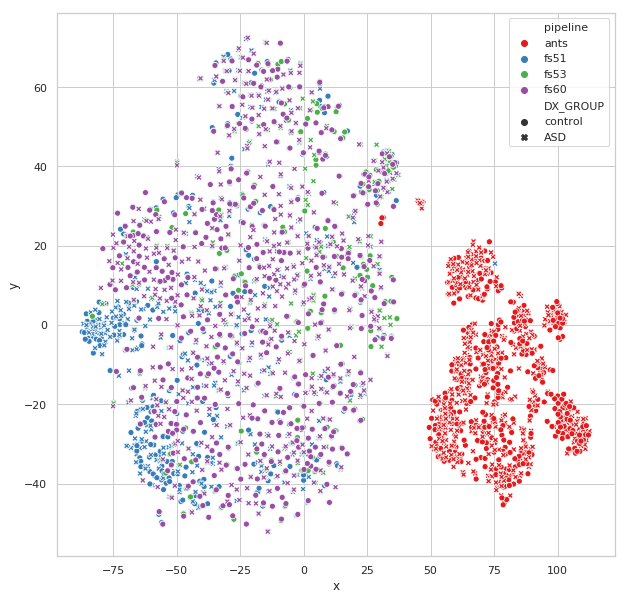

In [26]:
# plot
embed_df = pd.DataFrame(columns=['x','y'],data=X_embedded)
# embed_df['groupSowft'] = master_data_df_filtered['groupSowft'].values
embed_df['pipeline'] = master_data_df_filtered['pipeline'].values
embed_df['DX_GROUP'] = master_data_df_filtered['DX_GROUP'].values
#embed_df['outlier'] = master_data_df_filtered['outlier'].values

#embed_df['groupSowft'] = embed_df['groupSowft'].replace({1:'ants+control', 2:'fs5.1+control', 3:'fs5.3+control',
#                                                          4:'ants+ASD', 5:'fs5.1+ASD', 6:'fs5.3+ASD'})

#embed_df['Outlier'] = embed_df['Outlier'].replace({1:'outlier', 0:'normal'})
embed_df['DX_GROUP'] = embed_df['DX_GROUP'].replace({1:'control', 2:'ASD'})

plt.figure(figsize=(10,10))
sns.set(font_scale=1) 
with sns.axes_style("whitegrid"):
    g = sns.scatterplot(x='x',y='y',hue='pipeline',style='DX_GROUP',
                    data=embed_df,palette="Set1")
    #g.figure.savefig('/Users/nikhil/Desktop/tsne.png', dpi=300)

## ML classifier - sanity check

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import svm

pipe_pairs = {'ants' : ['ants'],
              'fs5.1' : ['fs51'],
              'fs5.3' : ['fs53'],
             'fs6.0' : ['fs60']}
# pipe_pairs = {'ants vs. fs5.1' : ['ants','fs51'],
#               'ants vs. fs5.3' : ['ants','fs53'],
#               'fs5.1 vs. fs5.3' : ['fs51','fs53']}

n_splits = 10
n_repeats = 10
all_scores = pd.DataFrame(columns=['pipeline','Acc'])
scores = pd.DataFrame(columns=['pipeline','Acc'])
for i, pair in enumerate(pipe_pairs.keys()):
    ml_df = master_data_df_filtered[master_data_df_filtered['pipeline'].isin(pipe_pairs[pair])]
    X = ml_df[common_roi_cols].values
    y = pd.get_dummies(ml_df['DX_GROUP']).values[:,0]

    clf = svm.SVC(kernel='linear')
    acc = cross_val_score(clf, X, y, cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats))
    scores['pipeline'] = np.tile(pair,len(acc))
    scores['Acc'] = acc
    all_scores = all_scores.append(scores)

    print('DX {}, discriminative acc mean:{:4.3f}, stdev:{:4.3f}'.format(pair,np.mean(acc),np.std(acc)))

DX ants, discriminative acc mean:0.580, stdev:0.055
DX fs5.3, discriminative acc mean:0.563, stdev:0.050
DX fs6.0, discriminative acc mean:0.549, stdev:0.054
DX fs5.1, discriminative acc mean:0.548, stdev:0.051


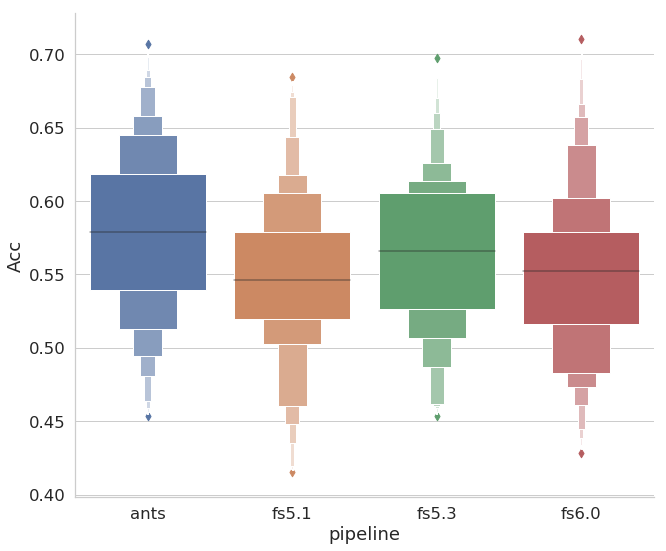

In [32]:
x_order = ['ants','fs5.1','fs5.3','fs6.0']
sns.set(font_scale=1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='Acc',x='pipeline',data=all_scores,kind='boxen',order=x_order,aspect=1.2,height=8)

In [33]:
g.savefig('/Users/nikhil/Desktop/ml.png', dpi=300)

# Sample Research Question
* Predict age from cortical thickness

In [33]:
ml_df['DX_GROUP'].value_counts()

2    398
1    362
Name: DX_GROUP, dtype: int64

In [36]:
import statsmodels.api as sm

useful_demograph = pheno[['SubjID','FIQ','BMI']]
study_data_df = pd.merge(master_data_df_filtered, useful_demograph, how='left', on='SubjID')
print(study_data_df.shape)

(3040, 69)


## OLS: age ~ cortical_thickness [+ sex + Dx] 

In [106]:
# PCA based multiple regression with all ROIs
from sklearn.decomposition import PCA

dependent_var = 'AGE_AT_SCAN' #(either AGE_AT_SCAN of DX_GROUP)
results_df = pd.DataFrame(columns=list(range(n_pc)) + ['pipeline','metric'])
p = 0
n_pc = 10
for pipe in set(study_data_df['pipeline'].values):
    analysis_df = study_data_df[study_data_df['pipeline']==pipe]
    if dependent_var =='DX_GROUP':
        y = pd.get_dummies(analysis_df['DX_GROUP']).values[:,0]
    else:
        y = analysis_df[dependent_var].values
    
    # OLS or Logit
    t_val_list = []
    p_val_list = []
    R2_adj_list = []
    ci_val_list = []
    
    #pca
    X_roi = analysis_df[common_roi_cols]
    pca = PCA(n_components=n_pc)
    pca.fit(X_roi)
    print(pipe)
    print(pca.explained_variance_ratio_)
    X_pca = pca.transform(X_roi)
    
    if dependent_var =='DX_GROUP':
        X = np.hstack((X_pca, analysis_df[['SEX','AGE_AT_SCAN']].values))
        print(X.shape)
        model = sm.Logit(y,X)
    else:
        X = np.hstack((X_pca, analysis_df[['SEX','DX_GROUP']].values))
        print(X.shape)
        #X = sm.add_constant(X)
        model = sm.OLS(y,X)
        
    results = model.fit()
    t_val = results.tvalues[:n_pc] # just for ROI
    p_val = results.pvalues[:n_pc] # just for ROI
    ci_val = results.conf_int()[n_pc]
    t_val_list.append(t_val)
    p_val_list.append(p_val)
    ci_val_list.append(ci_val)

    if dependent_var =='AGE_AT_SCAN':
        r2_adj_val = results.rsquared_adj
        R2_adj_list.append(r2_adj_val)

#     results_df.loc[p] = list(t_val_list) + [pipe,'t_val']
#     p+=1
    results_df.loc[p] = list(p_val_list[0]) + [pipe,'p_val']
#     results_df.loc[p] = list(conf_int_val_list) + [pipe,'p_val']
    p+=1

#     if dependent_var =='AGE_AT_SCAN':
#         results_df.loc[p] = list(R2_adj_list) + [pipe,'R2_adj']
#         p+=1

ants
[0.38799686 0.14946704 0.08306207 0.05664352 0.0461757  0.03326785
 0.0260681  0.01966363 0.01694107 0.01568946]
(929, 12)
fs53
[0.39386342 0.11489463 0.07838102 0.04870244 0.04332052 0.03168397
 0.02668937 0.0190355  0.01748631 0.0154556 ]
(915, 12)
fs51
[0.45474285 0.09913386 0.06722466 0.04430357 0.03830347 0.02860317
 0.02327651 0.0218441  0.0157527  0.01482805]
(946, 12)


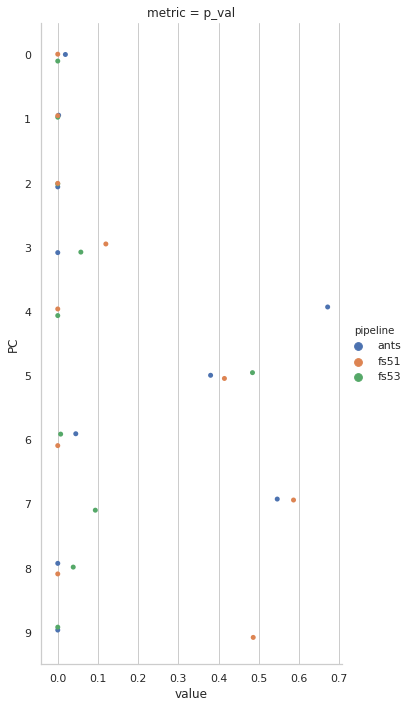

In [104]:
results_df_melt = pd.melt(results_df, id_vars=['pipeline','metric'], value_vars=list(range(n_pc)),
                             var_name='PC', value_name='value')

hue_order = ['ants','fs51','fs53']
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x = 'value', y='PC', hue='pipeline', col='metric', data=results_df_melt,
                    orient='h',kind='strip',aspect=0.5,height=10,sharex=False,hue_order=hue_order)

In [37]:
# For proof-of-concept, currently implemented as multiple regression instead of mass-univariate

dependent_var = 'DX_GROUP' #(either AGE_AT_SCAN of DX_GROUP)
results_df = pd.DataFrame(columns=common_roi_cols + ['pipeline','metric'])
p = 0
for pipe in set(study_data_df['pipeline'].values):
    analysis_df = study_data_df[study_data_df['pipeline']==pipe]
    if dependent_var =='DX_GROUP':
        y = pd.get_dummies(analysis_df['DX_GROUP']).values[:,0]
    else:
        y = analysis_df[dependent_var].values
    
    # OLS or Logit
    t_val_list = []
    p_val_list = []
    R2_adj_list = []
    ci_val_list = []
    
    for roi in common_roi_cols:
        if dependent_var =='DX_GROUP':
            X = analysis_df[[roi,'SEX','AGE_AT_SCAN']].values
            model = sm.Logit(y,X)
        else:
            X = analysis_df[[roi,'SEX','DX_GROUP']].values
            #X = sm.add_constant(X)
            model = sm.OLS(y,X)
        
        results = model.fit()
        t_val = results.tvalues[0] # just for ROI
        p_val = results.pvalues[0] # just for ROI
        ci_val = results.conf_int()[0]
        t_val_list.append(t_val)
        p_val_list.append(p_val)
        ci_val_list.append(ci_val)
        
        if dependent_var =='AGE_AT_SCAN':
            r2_adj_val = results.rsquared_adj
            R2_adj_list.append(r2_adj_val)
        
#     results_df.loc[p] = list(t_val_list) + [pipe,'t_val']
#     p+=1
    results_df.loc[p] = list(p_val_list) + [pipe,'p_val']
    p+=1

#     if dependent_var =='AGE_AT_SCAN':
#         results_df.loc[p] = list(R2_adj_list) + [pipe,'R2_adj']
#         p+=1

Optimization terminated successfully.
         Current function value: 17.901535
         Iterations 4
Optimization terminated successfully.
         Current function value: 20.177271
         Iterations 4
Optimization terminated successfully.
         Current function value: 18.670238
         Iterations 4
Optimization terminated successfully.
         Current function value: 19.086354
         Iterations 4
Optimization terminated successfully.
         Current function value: 18.347268
         Iterations 4
Optimization terminated successfully.
         Current function value: 17.773695
         Iterations 4
Optimization terminated successfully.
         Current function value: 19.487447
         Iterations 4
Optimization terminated successfully.
         Current function value: 18.197658
         Iterations 4
Optimization terminated successfully.
         Current function value: 18.671119
         Iterations 4
Optimization terminated successfully.
         Current function value: 18

Optimization terminated successfully.
         Current function value: 18.072098
         Iterations 4
Optimization terminated successfully.
         Current function value: 17.480563
         Iterations 4
Optimization terminated successfully.
         Current function value: 17.453777
         Iterations 4
Optimization terminated successfully.
         Current function value: 18.249046
         Iterations 4
Optimization terminated successfully.
         Current function value: 18.448541
         Iterations 4
Optimization terminated successfully.
         Current function value: 18.070191
         Iterations 4
Optimization terminated successfully.
         Current function value: 17.376419
         Iterations 4
Optimization terminated successfully.
         Current function value: 17.469564
         Iterations 4
Optimization terminated successfully.
         Current function value: 17.629012
         Iterations 4
Optimization terminated successfully.
         Current function value: 17

Optimization terminated successfully.
         Current function value: 17.748465
         Iterations 4
Optimization terminated successfully.
         Current function value: 17.883253
         Iterations 4
Optimization terminated successfully.
         Current function value: 18.243114
         Iterations 4
Optimization terminated successfully.
         Current function value: 18.269630
         Iterations 4
Optimization terminated successfully.
         Current function value: 17.257051
         Iterations 4
Optimization terminated successfully.
         Current function value: 17.423467
         Iterations 4
Optimization terminated successfully.
         Current function value: 17.813985
         Iterations 4
Optimization terminated successfully.
         Current function value: 17.437776
         Iterations 4
Optimization terminated successfully.
         Current function value: 17.512588
         Iterations 4
Optimization terminated successfully.
         Current function value: 17

In [71]:
results.summary()

/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/statsmodels/discrete/discrete_model.py:3313: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  975
Model:                          Logit   Df Residuals:                      972
Method:                           MLE   Df Model:                            2
Date:                Tue, 18 Dec 2018   Pseudo R-squ.:                     inf
Time:                        20:08:23   Log-Likelihood:                -22064.
converged:                       True   LL-Null:                        0.0000
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1103      0.085      1.291      0.197      -0.057       0.278
x2            -0.4663      0.174     -2.676      0.007      -0.808      -0.125
x3             0.0051      0.007      0.707      0.480      -0.009       0.019
==============================================================================
"""

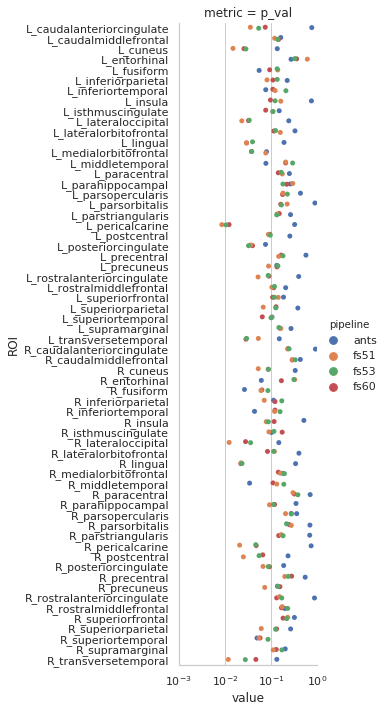

In [40]:
#Plot model results per pipeline

results_df_melt = pd.melt(results_df, id_vars=['pipeline','metric'], value_vars=common_roi_cols,
                             var_name='ROI', value_name='value')

hue_order = ['ants','fs51','fs53','fs60']
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x = 'value', y='ROI', hue='pipeline', col='metric', data=results_df_melt,order=roi_order,
                    orient='h',kind='strip',aspect=0.5,height=10,sharex=False,hue_order=hue_order)
    g.set(xscale="log");
    g.ax.set_xlim(1e-3, 1)
    
#     g.map(sns.stripplot, size=10)